In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [43]:
df = pd.read_csv("EEG Eye State.csv", skiprows = [i for i in range(19)], header=None)
df = df.values
# 0 - eye_open
# 1 - eye_closed

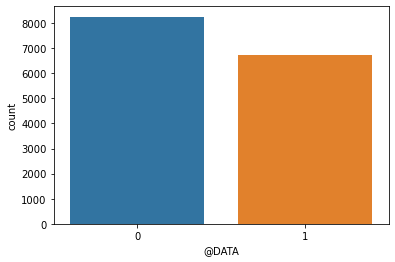

In [25]:
sns.countplot(x = '@DATA', data=df)

In [49]:
X = df[:,:14]
y = df[:,14:]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [53]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [54]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [55]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [56]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [64]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(14, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [66]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=14, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [67]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [87]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.30049 | Acc: 87.280
Epoch 002: | Loss: 0.27303 | Acc: 88.541
Epoch 003: | Loss: 0.26029 | Acc: 89.318
Epoch 004: | Loss: 0.24192 | Acc: 90.115
Epoch 005: | Loss: 0.23378 | Acc: 90.013
Epoch 006: | Loss: 0.21698 | Acc: 90.981
Epoch 007: | Loss: 0.20159 | Acc: 91.885
Epoch 008: | Loss: 0.20664 | Acc: 91.510
Epoch 009: | Loss: 0.19876 | Acc: 92.064
Epoch 010: | Loss: 0.18971 | Acc: 92.484
Epoch 011: | Loss: 0.19094 | Acc: 92.363
Epoch 012: | Loss: 0.17844 | Acc: 92.917
Epoch 013: | Loss: 0.17706 | Acc: 92.701
Epoch 014: | Loss: 0.17325 | Acc: 93.019
Epoch 015: | Loss: 0.16598 | Acc: 93.567
Epoch 016: | Loss: 0.15897 | Acc: 93.752
Epoch 017: | Loss: 0.15638 | Acc: 93.624
Epoch 018: | Loss: 0.15890 | Acc: 93.478
Epoch 019: | Loss: 0.15687 | Acc: 93.573
Epoch 020: | Loss: 0.15761 | Acc: 93.701
Epoch 021: | Loss: 0.13967 | Acc: 94.510
Epoch 022: | Loss: 0.14602 | Acc: 94.166
Epoch 023: | Loss: 0.14282 | Acc: 94.287
Epoch 024: | Loss: 0.14077 | Acc: 94.350
Epoch 025: | Los

In [88]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [89]:
confusion_matrix(y_test, y_pred_list)

array([[1917,  801],
       [1088, 1138]])

In [90]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.64      0.71      0.67      2718
         1.0       0.59      0.51      0.55      2226

    accuracy                           0.62      4944
   macro avg       0.61      0.61      0.61      4944
weighted avg       0.61      0.62      0.61      4944

